# Idealized Scenario

## Starting Values and Simulation

 Importing supporting libraries and declaring key  variables

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist

# Parameters
twistfirst = 1
twistsecond = 0.9
twistthird = 0.8
papers_in_journal = 12
number_of_journals = 25
author_dist_mean = 0.5
author_dist_stddev = 0.2
qual_var_stddev = 0.2
self_error_stddev = 0.0001
reviewer_error_stddev = 0.0001
rounds = 501
number_of_authors = 200




Generate author distributions

In [2]:
author_dist = np.random.normal(author_dist_mean, author_dist_stddev, number_of_authors)

Generate quality variations

In [3]:
qual_var = np.random.normal(0, qual_var_stddev, number_of_authors)

Generate self error variations

In [4]:
self_error = np.random.normal(0, self_error_stddev, number_of_authors)

Generate reviewer error variations

In [5]:
reviewer_error = np.random.normal(0, reviewer_error_stddev, number_of_authors)

Generate journal qualities

In [6]:
journals=np.zeros(number_of_journals)
journalspace = np.zeros((rounds, number_of_journals))

for i in range(1,number_of_journals+1):
    journals[i-1]=NormalDist(mu=0.5, sigma=0.15).inv_cdf(i/(number_of_journals+0.01))

Array to track the papers accepted by each author for each round

In [7]:
accepted = np.zeros((rounds, number_of_authors))

Generate initial author scores

In [8]:
autoren=author_dist

Arrays to track papers and their evaluations for each round

In [9]:
papers = np.zeros((rounds, number_of_authors))
einschaetzung = np.zeros((rounds, number_of_authors))

Array to track the quality of journals for each round

In [10]:
jourqual = np.zeros((rounds + 1, number_of_journals))
jourqual[0] = journals

Function to update Wunschliste for twistfirst

In [11]:
def update_wunschliste(twistfactor,jour_list,einschaetzung,wunschliste,r,number_of_authors):
    for i in range(number_of_authors):
        nearest_value = np.abs(jour_list - twistfactor * einschaetzung[r,i]).argmin()
        wunschliste[i] = nearest_value
    
 
    

Function to update Wunschliste for twistsecond and twistfirst

In [12]:
def update_wunschliste_2(twistfactor,jour_list,einschaetzung,accepted,wunschliste,r,number_of_authors):
    for i in range(number_of_authors):
        if accepted[r, i] == 0:
            nearest_value = np.abs(jour_list - twistfactor * einschaetzung[r,i]).argmin()
            wunschliste[i] = nearest_value

Function to update Journalspace for twistfirst

In [13]:
def update_journalspace(wunschliste,accepted,gutachten,journalspace,r):
    for ran in range(number_of_journals, 0, -1):
        if np.count_nonzero(wunschliste == ran-1) <= papers_in_journal:
        # Assign ran to corresponding positions in accepted array
            accepted[r, np.where(wunschliste == ran-1)] = ran-1
        else:
            sorted_indices = np.argsort(gutachten.flatten())
            selected_indices = np.where(np.isin(wunschliste, ran-1))
            sorted_selected_indices = sorted_indices[np.in1d(sorted_indices, selected_indices)]
            for j in range(1, papers_in_journal + 1):
                accepted_indices = np.where(gutachten.flatten() == np.take(sorted_selected_indices, -j))[0]
                accepted[r, accepted_indices] = ran-1

        journalspace[r, ran-1] = np.count_nonzero(accepted[r] == ran-1)
    

Function to update Journalspace for twistsecond and twistthird

In [14]:
def update_journalspace_2(wunschliste,accepted,gutachten,journalspace,r):
    for ran in range(number_of_journals, 0, -1):
        if journalspace[r, ran - 1] < papers_in_journal: 
            
            if journalspace[r, ran-1] + np.count_nonzero(wunschliste == ran-1) <= papers_in_journal:
            # Assign papers from wunschliste to the journal
                accepted_indices = np.where(wunschliste == ran-1)[0]
                accepted[r, accepted_indices] = ran-1
            else:
                sorted_indices = np.argsort(gutachten.flatten())
                selected_indices = np.where(np.isin(wunschliste, ran-1))[0]
                sorted_selected_indices = sorted_indices[np.in1d(sorted_indices, selected_indices)]
                for j in range(1, int(papers_in_journal - journalspace[r, ran-1] + 1)):
                    accepted_indices = np.where(gutachten.flatten() == np.take(sorted_selected_indices, j*-1))[0]
                    accepted[r, accepted_indices] = ran-1
    

        journalspace[r, ran - 1] = np.count_nonzero(accepted[r] == ran-1)
    

Function to update Journal quality for a particular round

In [15]:
def update_jourqual(journalspace,accepted,papers,jourqual,r,number_of_journals):
    for ran in range(number_of_journals):
        if journalspace[r, ran] == 0:
            jourqual[r + 1, ran] = (5/5) * jourqual[r, ran]
        else:
            indices = np.where(accepted[r] == ran)
            jourqual[r + 1, ran] = (4/5) * jourqual[r, ran] + (1/5) * np.mean(papers[r, indices])

Function to run the simulation for all the rounds to calculate journal quality

In [16]:
def simulate(rounds,number_of_authors,number_of_journals,papers_in_journal):
    for r in range(rounds):
        
        #initialize key parameters for twistfirst
        papers[r] = autoren * (1 + np.random.normal(0, qual_var_stddev, number_of_authors))
        einschaetzung[r] = papers[r] * (1 + np.random.normal(0, self_error_stddev, number_of_authors))

        gutachten = papers[r] * (1 + np.random.normal(0, reviewer_error_stddev, number_of_authors))
        wunschliste = np.zeros(number_of_authors)

        #Update Wunschliste for twistfirst
        update_wunschliste(twistfirst,jourqual[r],einschaetzung,wunschliste,r,number_of_authors)
        
        #update journalspace for twistfirst
        update_journalspace(wunschliste,accepted,gutachten,journalspace,r)
        
        #initialize key parameters for twistsecond
        wunschliste = np.zeros(number_of_authors)
        gutachten = papers[r] *  (1 + np.random.choice(reviewer_error, number_of_authors))
        
        
        #Update Wunschliste for twistsecond
        update_wunschliste_2(twistsecond,jourqual[r],einschaetzung,accepted,wunschliste,r,number_of_authors)
        
        #update journalspace for twistsecond
        update_journalspace_2(wunschliste,accepted,gutachten,journalspace,r)
        
        #initialize key parameters for twistthird
        wunschliste = np.zeros(number_of_authors)
        gutachten = papers[r] *  (1 + np.random.choice(reviewer_error, number_of_authors))
                                 
        
        #Update Wunschliste for twistthird
        update_wunschliste_2(twistthird,jourqual[r],einschaetzung,accepted,wunschliste,r,number_of_authors)
        
        #update journalspace for twistthird
        update_journalspace_2(wunschliste,accepted,gutachten,journalspace,r)
    
        #update jourqual for all the three twists
        update_jourqual(journalspace,accepted,papers,jourqual,r,number_of_journals)                          


Function to plot journal quality

In [17]:
def plot_jourqual(jourqual,rounds,number_of_journals):
    import matplotlib.pyplot as plt


    # Transpose jourqual and select the desired rows using slicing
    data = np.array([jourqual[k][np.argsort(jourqual[-1])[:number_of_journals]] for k in range(50, rounds)])

    plt.figure(figsize=(8, 6))

    # Plot the data
    for i in range(number_of_journals):
        plt.plot(data[:, i], label=f'Journal {i+1}', linewidth=0.5)

    # Set plot attributes
    plt.xlabel('Periods')
    plt.ylabel('Journal Quality')
    plt.title('')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Rotate labels
    plt.xticks(rotation=45)

    # Set label styles
    plt.xlabel('periods', fontsize=11)
    plt.ylabel('journal quality', fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show() 


Function to plot journal quality for top 3 journals

In [18]:
def plot_jourqual_top3(jourqual,rounds,number_of_journals):
    import numpy as np
    import matplotlib.pyplot as plt


    mean_values = np.mean(jourqual, axis=0)

    # Sort the mean values and get the indices of the elements at positions (numberofjournals - 2) and (numberofjournals - 1)
    sorted_indices = np.argsort(mean_values)[number_of_journals - 4:number_of_journals]

    # Select the elements from jourqual corresponding to the sorted indices for the range from 50 to rounds
    selected_journals = [jourqual[k][sorted_indices] for k in range(50, rounds + 1)]

    # Transpose the selected_journals array
    selected_journals_transposed = np.array(selected_journals)

    # Plot the transposed array
    plt.figure()
    plt.plot(selected_journals_transposed[:,0], linestyle='-', linewidth=1, color='green', alpha=0.5)
    plt.plot(selected_journals_transposed[:,1], linestyle='-', linewidth=1, color='purple')
    plt.plot(selected_journals_transposed[:,2], linestyle='-', linewidth=1, color='orange')
    plt.xlabel('periods', fontsize=12)
    plt.ylabel('journal quality', fontsize=12)
    plt.title('')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    #plt.gca().invert_xaxis()  # Invert x-axis to match Mathematica's behavior
    #plt.gca().invert_yaxis()  # Invert y-axis to match Mathematica's behavior
    plt.gca().xaxis.set_label_position('bottom')
    plt.gca().yaxis.set_label_position('left')
    plt.gca().tick_params(axis='both', which='both', direction='out')
    plt.gca().tick_params(axis='both', which='major', length=5)
    plt.gca().tick_params(axis='both', which='minor', length=3)
    plt.show()


Function to plot journal quality for medium 3 journals

In [19]:
def plot_jourqual_medium3(jourqual,rounds,number_of_journals):
    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming jourqual is a NumPy array

    # Calculate the mean along columns
    mean_values = np.mean(jourqual, axis=0)

    # Sort the mean values and get the indices of the elements at positions (numberofjournals - 2) and (numberofjournals - 1)
    sorted_indices = np.argsort(mean_values)[number_of_journals - 13:number_of_journals-10]

    # Select the elements from jourqual corresponding to the sorted indices for the range from 50 to rounds
    selected_journals = [jourqual[k][sorted_indices] for k in range(50, rounds + 1)]

    # Transpose the selected_journals array
    selected_journals_transposed = np.array(selected_journals)

    # Plot the transposed array
    plt.figure()
    plt.plot(selected_journals_transposed[:,0], linestyle='-', linewidth=1, color='green', alpha=0.5)
    plt.plot(selected_journals_transposed[:,1], linestyle='-', linewidth=1, color='purple')
    plt.plot(selected_journals_transposed[:,2], linestyle='-', linewidth=1, color='orange')
    plt.xlabel('periods', fontsize=12)
    plt.ylabel('journal quality', fontsize=12)
    plt.title('')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    #plt.gca().invert_xaxis()  # Invert x-axis to match Mathematica's behavior
    #plt.gca().invert_yaxis()  # Invert y-axis to match Mathematica's behavior
    plt.gca().xaxis.set_label_position('bottom')
    plt.gca().yaxis.set_label_position('left')
    plt.gca().tick_params(axis='both', which='both', direction='out')
    plt.gca().tick_params(axis='both', which='major', length=5)
    plt.gca().tick_params(axis='both', which='minor', length=3)
    plt.show()


Function to plot journal quality for worst journals

In [20]:
def plot_jourqual_worst(jourqual,rounds,number_of_authors):
    import numpy as np
    import matplotlib.pyplot as plt

    # Define constants
    RANG = 25

    # Calculate histogram data
    hist_data = []
    for r in range(rounds):
        selected_papers = []
        # Assuming that accepted is a 2D array where the second dimension is 'numberofauthors'
        for i in range(number_of_authors):
            # Check if the index is within bounds
            if (number_of_journals - RANG) >= 0:
                index = number_of_journals - RANG
                if accepted[r, i] == np.argsort(jourqual[-1])[index]:
                    selected_papers.append(papers[r, i])
            else:
                print("Error: Index out of bounds.")
        hist_data.extend(selected_papers)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.hist(hist_data, bins='auto', color='purple')
    plt.xlabel('Manuscript quality')
    plt.ylabel('Number of manuscripts')
    plt.title('Histogram of Manuscript Quality')
    plt.grid(True)
    plt.show()


Function to plot Paper Density vs rejection rate

In [21]:
def plot_paper_density_vs_rejection_rate(accepted,papers,number_of_authors,rounds):
    rej = []
    for ch in range(31):
        rejected = sum(len([author for author in range(number_of_authors) if ch/20 < papers[r][author] < (ch + 1)/20 and accepted[r][author] == 0]) for r in range(rounds))
        total = sum(len([author for author in range(number_of_authors) if ch/20 < papers[r][author] < (ch + 1)/20]) for r in range(rounds))
        rej.append(rejected / (1 + total))


    total = []
    for ch in range(31):
        total_in_range = sum(len([author for author in range(number_of_authors) if ch/20 < papers[r][author] < (ch + 1)/20]) for r in range(rounds))
        total.append(total_in_range)

    import matplotlib.pyplot as plt


    fig, ax = plt.subplots()

    # Plot the rejection rate and normalized paper density
    ax.plot(range(31), rej, color='purple', linewidth=2, label='Rejection Rate')
    ax.plot(range(31), [t/(rounds*number_of_authors/12) for t in total], color='orange', linewidth=2, label='Paper Density (normalized)')

    # Set the range of the plot
    ax.set_xlim([0, 30])
    ax.set_ylim([0, 1.18])

    # Set the ticks on the axes
    ax.set_xticks([5, 10, 15, 20, 25, 30])
    ax.set_yticks([0.25, 0.5, 0.75, 1, 1.25, 1.5])

    # Add labels for the lines
    ax.text(20, 0.8, 'Paper Density (normalized)', color='orange', fontsize=10)
    ax.text(14, 0.2, 'Rejection Rate', color='purple', fontsize=10)

    # Label the x-axis
    plt.xlabel('manuscript quality')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()



Function to plot destiny of top 20% papers

In [22]:
def plot_destiny_top20(papers,number_of_authors,rounds):
    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming papers and accepted are 2D arrays
    top20 = np.take(np.sort(papers.flatten(), axis=None)[::-1], int((rounds * number_of_authors) / 5))
    final = np.zeros(number_of_authors * rounds)
    parameter = np.min(top20)
    co = 0

    for in1 in range(1, rounds + 1):
        for in2 in range(1, number_of_authors + 1):
            if parameter <= papers[in1 - 1, in2 - 1]:
                final[co] = accepted[in1 - 1, in2 - 1]
            else:
                final[co] = -1
            co += 1

    sel20 = final[final >= 0]

    plt.figure(figsize=(8, 6))
    plt.hist(sel20, bins=25, color='purple')
    plt.xlabel('Journals ranked according to quality')
    plt.ylabel('Number of top 20% papers')
    plt.title('Histogram of Top 20% Papers')
    plt.grid(True)
    plt.show()


Calling simulate function to calculate journal quality

In [23]:
simulate(rounds,number_of_authors,number_of_journals,papers_in_journal)

Development of Journal Quality over Time

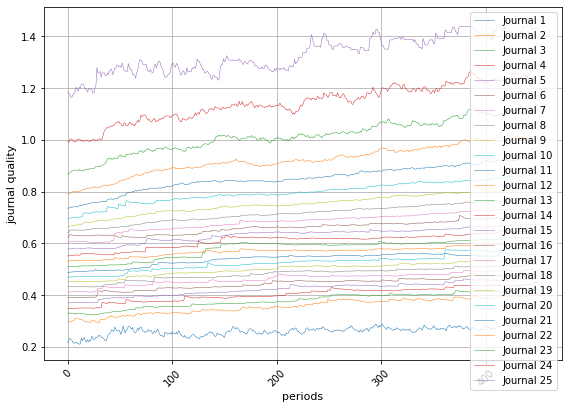

In [24]:
plot_jourqual(jourqual,rounds,number_of_journals)

Development of Journal Quality over Time: Top 3

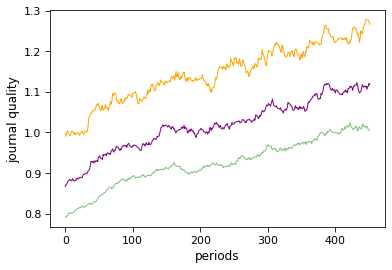

In [25]:
plot_jourqual_top3(jourqual,rounds,number_of_journals)

Development of Journal Quality over Time: Medium 3

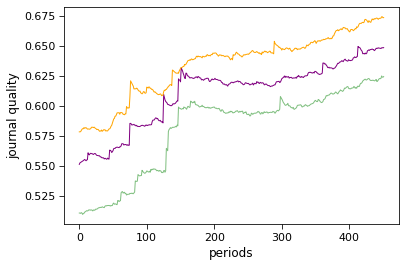

In [26]:
plot_jourqual_medium3(jourqual,rounds,number_of_journals)

Quality of Papers published in the worst journal

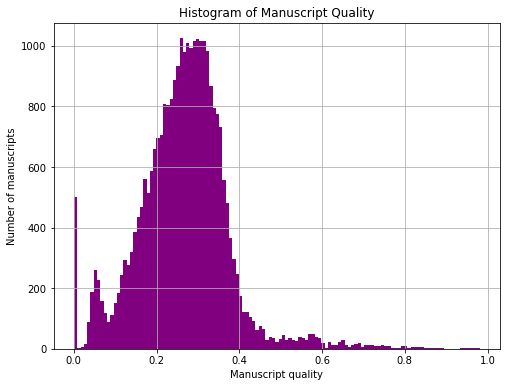

In [27]:
plot_jourqual_worst(jourqual,rounds,number_of_authors)

Paper Density vs. Rejection Rate

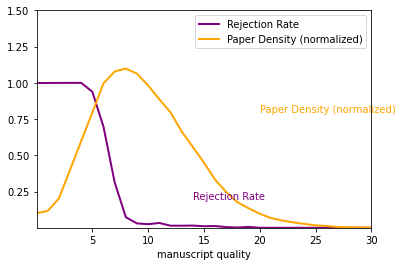

In [28]:
plot_paper_density_vs_rejection_rate(accepted,papers,number_of_authors,rounds)

The destiny of the top 20% of papers

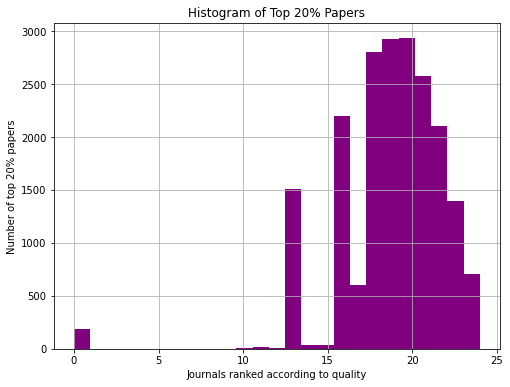

In [29]:
plot_destiny_top20(papers,number_of_authors,rounds)

# Noisy Scenario

## Starting Values and Simulation 

Importing supporting libraries and declaring key variables

In [30]:

import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist

# Parameters
twistfirst = 1.1
twistsecond = 1
twistthird = 0.9
papers_in_journal = 12
number_of_journals = 25
author_dist_mean = 0.5
author_dist_stddev = 0.2
qual_var_stddev = 0.2
self_error_stddev = 0.2
reviewer_error_stddev = 0.2
rounds = 501
number_of_authors = 200


Generate author distributions

In [31]:
author_dist = np.random.normal(author_dist_mean, author_dist_stddev, number_of_authors)

Generate quality variations

In [32]:
qual_var = np.random.normal(0, qual_var_stddev, number_of_authors)

Generate self error variations

In [33]:
self_error = np.random.normal(0, self_error_stddev, number_of_authors)

Generate reviewer error variations

In [34]:
reviewer_error = np.random.normal(0, reviewer_error_stddev, number_of_authors)

Generate journal qualities

In [35]:
journals=np.zeros(number_of_journals)
journalspace = np.zeros((rounds, number_of_journals))

for i in range(1,number_of_journals+1):
    journals[i-1]=NormalDist(mu=0.5, sigma=0.15).inv_cdf(i/(number_of_journals+0.01))

Array to track the papers accepted by each author for each round

In [36]:
accepted = np.zeros((rounds, number_of_authors))

Generate initial author scores

In [37]:
autoren=author_dist

Arrays to track papers and their evaluations for each round

In [38]:
papers = np.zeros((rounds, number_of_authors))
einschaetzung = np.zeros((rounds, number_of_authors))

Array to track the quality of journals for each round

In [39]:
jourqual = np.zeros((rounds + 1, number_of_journals))
jourqual[0] = journals

Calling simulate function to calculate journal quality

In [40]:
simulate(rounds,number_of_authors,number_of_journals,papers_in_journal)

Development of Journal Quality over Time

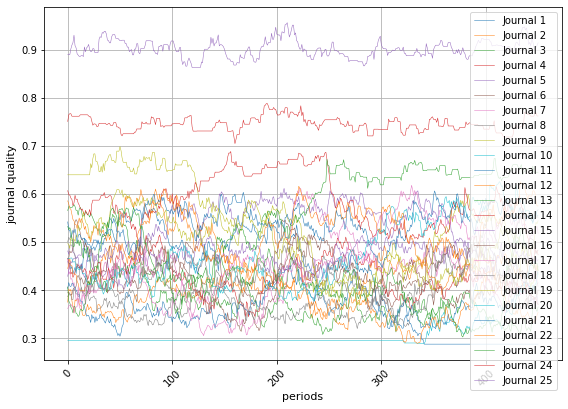

In [41]:
plot_jourqual(jourqual,rounds,number_of_journals)

Development of Journal Quality over Time: Top 3

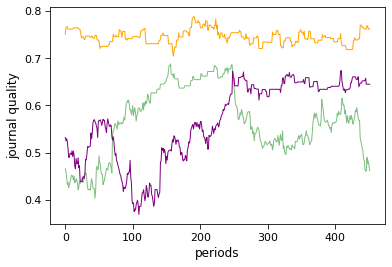

In [42]:
plot_jourqual_top3(jourqual,rounds,number_of_journals)

Development of Journal Quality over Time: Medium 3

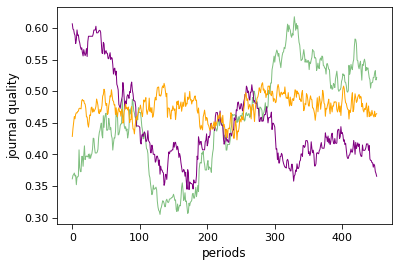

In [43]:
plot_jourqual_medium3(jourqual,rounds,number_of_journals)

Quality of Papers published in the worst journal

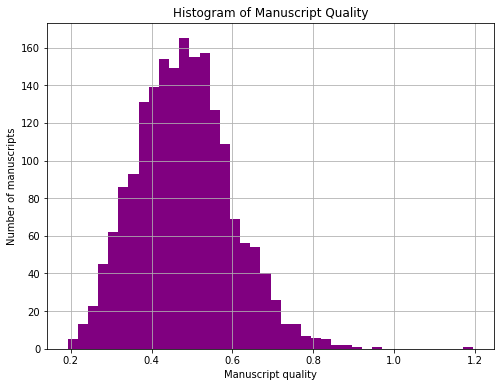

In [44]:
plot_jourqual_worst(jourqual,rounds,number_of_authors)

Paper Density vs. Rejection Rate

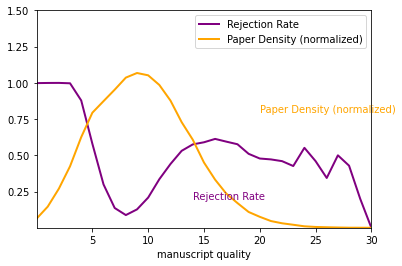

In [45]:
plot_paper_density_vs_rejection_rate(accepted,papers,number_of_authors,rounds)